In [1]:

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras
import tensorflow as tf
from scipy.stats import t
from scipy.stats import norm
from tensorflow.keras import backend as K
import time

C:\Users\DAIICT J\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


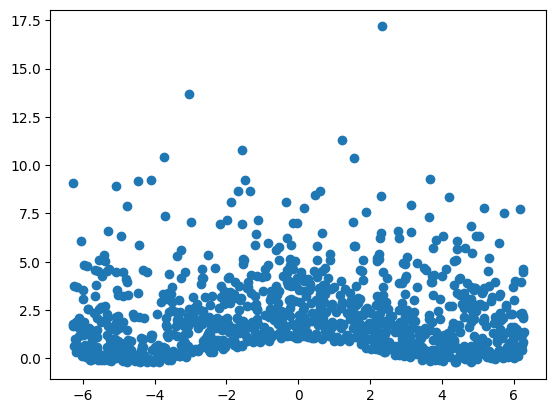

In [2]:
np.random.seed(40)

n_samples = 1000  # Example number of samples

# Generate noise from chi-square distribution with degree of freedom 2
noise = np.random.chisquare(df=2, size=n_samples)

# Generate X values uniformly
X = np.random.uniform(low=-2 * np.pi, high=2 * np.pi, size=(n_samples, 1))

# Compute y values with the chi-square noise
y = (np.sin(X[:, 0]) / X[:, 0]) + noise
y_ = (np.sin(X[:, 0]) / X[:, 0])

# Prepare data for training
X_train = X.reshape(-1)
y_train = y.reshape(-1)
y_train = np.stack((y_train, y_train), axis=1)

# Create a grid for visualization
x_grid = np.linspace(-6, 6, 3000)
# plot the points
plt.scatter(X_train,y_train[:,0])

In [3]:
import time
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def quantile_loss(q):
    def loss(y_true, y_pred):
        y = y_true[:, 0]
        e = y - y_pred[:, 0]
        return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))
    return loss


class ANNQuantileReg:
    def __init__(
        self,
        input_dim=1,
        hidden_dim=200,
        q=0.5,
        lr=0.02
    ):
        self.q = q
        self.model = self._build_model(input_dim, hidden_dim)
        self._compile(lr)

    def _build_model(self, input_dim, hidden_dim):
        model = Sequential()
        model.add(Dense(
            hidden_dim,
            input_dim=input_dim,
            activation='relu',
            kernel_initializer=keras.initializers.RandomNormal(0.0, 0.2)
        ))
        # model.add(Dense(
        #     hidden_dim,
        #     activation='relu',
        #     kernel_initializer=keras.initializers.RandomNormal(0.0, 0.2)
        # ))
        model.add(Dense(
            1,  
            activation='linear',
            kernel_initializer=keras.initializers.RandomNormal(0.0, 0.3),
            bias_initializer=keras.initializers.Constant(0.0)
        ))
        return model

    def _compile(self, lr):
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=10000,
            decay_rate=0.01
        )
        opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        self.model.compile(
            optimizer=opt,
            loss=quantile_loss(self.q)
        )

    def fit(self, X, y, epochs=400, batch_size=40, verbose=0):
        start = time.time()
        self.model.fit(
            X, y,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose
        )
        self.train_time = time.time() - start
        return self.train_time

    def predict(self, X):
        return self.model.predict(X, verbose=0)[:, 0]


In [4]:


iterations = 5
metrics_records = []


for i in range(iterations):
    print(f"Iteration {i+1}/{iterations}")

    # lower_quantiles = [0.02,0.05,0.1,0.15,0.18]
    # upper_quantiles = [0.82,0.85,0.9,0.85,0.98]
    lower_quantiles = [0.15]
    upper_quantiles = [0.95]


    for q1,q2 in zip(lower_quantiles,upper_quantiles):
        

        


        model_l = ANNQuantileReg(q=q1)
        time_l = model_l.fit(X_train, y_train)


        model_u = ANNQuantileReg(q=q2)
        time_u = model_u.fit(X_train, y_train)

        total_train_time = time_l + time_u
        y_l = model_l.predict(X_train)
        y_u = model_u.predict(X_train)      

        K_u = y_u > y_train[:, 0]
        K_l = y_l < y_train[:, 0]

        PICP = np.mean(K_u * K_l)
        MPIW = np.mean(y_u - y_l)

        print(f"PICP (Pinball) q1={q1}, q2={q2}: {PICP:.3f}")
        print(f"MPIW (Pinball) q1={q1}, q2={q2}: {MPIW:.3f}")
        metrics_records.append({
            "iteration": i + 1,
            "q1": q1,
            "q2": q2,
            "PICP": PICP,
            "MPIW": MPIW,
            "training_time_sec": total_train_time
        })
     

        y_l_grid = model_l.predict(x_grid)
        y_u_grid = model_u.predict(x_grid)

        plt.scatter(X_train, y_train[:, 0], s=10, c='r')
        plt.plot(x_grid, y_u_grid, 'b', linewidth=3, label=f'q={q2}')
        plt.plot(x_grid, y_l_grid, 'b', linewidth=3, label=f'q={q1}')

        plt.title(
    f'Pinball Loss PI (q1={q1}, q2={q2})\n'
    f'Time={total_train_time:.2f}s',
    fontsize=18
)
        plt.savefig(f'Qunatile_Testing/Final_with_new_q1_{q1}_and_q2_{q2}_iteration{i+1}.png')
        plt.legend()
        plt.xlim(-6, 6)
        plt.close()
        
        
        

Iteration 1/5


c:\Users\Manush\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


PICP (Pinball) q1=0.15, q2=0.95: 0.799
MPIW (Pinball) q1=0.15, q2=0.95: 5.661
Iteration 2/5


KeyboardInterrupt: 

In [9]:
import pandas as pd
df = pd.DataFrame(metrics_records)
df.to_csv("Qunatile_Testing/Quantile_metrics_records.csv", index=False)